In [19]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
import io
from PIL import Image

from src.compound import Compound


def show_png(data):
    bio = io.BytesIO(data)
    img = Image.open(bio)
    return img

In [2]:
df = pd.read_csv('/home/ruard/code/virtual_reactions/data/datasets/da/da_no_solvent_dataset.csv')
df

,Unnamed: 0,reaction_idx,uid,substrates,products,reaction_smiles,labels,simulation_idx
0,0,2,0,C=C(C)C(=O)OC.COC1(OC)C=C(Br)C=CC1=O,COC(=O)C1(C)CC2C=C(Br)C1C(OC)(OC)C2=O,C=C(C)C(=O)OC.COC1(OC)C=C(Br)C=CC1=O>>COC(=O)C...,0,0.0
1,1,2,1,C=C(C)C(=O)OC.COC1(OC)C=C(Br)C=CC1=O,COC(=O)C1(C)CC2C(Br)=CC1C(=O)C2(OC)OC,C=C(C)C(=O)OC.COC1(OC)C=C(Br)C=CC1=O>>COC(=O)C...,1,0.0
2,2,6,2,C1=CCC=C1.COC1(OC)C(Cl)=C(Cl)C(Cl)=C1Cl,COC1(OC)C2(Cl)C(Cl)=C(Cl)C1(Cl)C1CC=CC12,C1=CCC=C1.COC1(OC)C(Cl)=C(Cl)C(Cl)=C1Cl>>COC1(...,1,0.0
3,3,6,3,C1=CCC=C1.COC1(OC)C(Cl)=C(Cl)C(Cl)=C1Cl,COC1(OC)C(Cl)=C(Cl)C2(Cl)C3C=CC(C3)C12Cl,C1=CCC=C1.COC1(OC)C(Cl)=C(Cl)C(Cl)=C1Cl>>COC1(...,0,0.0
4,4,7,4,C=CC(=O)CC.C=CC=CNC(=O)OCc1ccccc1,CCC(=O)C1CC=CC(NC(=O)OCc2ccccc2)C1,C=CC(=O)CC.C=CC=CNC(=O)OCc1ccccc1>>CCC(=O)C1CC...,0,0.0
...,...,...,...,...,...,...,...,...
1162,1162,1679,1162,C=CC=C(C(F)(F)F)C(F)(F)F.C=CC=C,C=CC1CC=CCC1(C(F)(F)F)C(F)(F)F,C=CC=C(C(F)(F)F)C(F)(F)F.C=CC=C>>C=CC1CC=CCC1(...,0,0.0
1163,1163,1679,1163,C=CC=C(C(F)(F)F)C(F)(F)F.C=CC=C,FC(F)(F)C(=CC1CC=CCC1)C(F)(F)F,C=CC=C(C(F)(F)F)C(F)(F)F.C=CC=C>>FC(F)(F)C(=CC...,1,0.0
1164,1164,1679,1164,C=CC=C(C(F)(F)F)C(F)(F)F.C=CC=C,C=CC1CC=CC(C(F)(F)F)(C(F)(F)F)C1,C=CC=C(C(F)(F)F)C(F)(F)F.C=CC=C>>C=CC1CC=CC(C(...,0,0.0
1165,1165,1680,1165,O=C1C=CC(=O)C(Cl)=C1Cl.C1=CCC=C1,O=C1C=CC(=O)C2(Cl)C3C=CC(C3)C12Cl,O=C1C=CC(=O)C(Cl)=C1Cl.C1=CCC=C1>>O=C1C=CC(=O)...,0,0.0


1


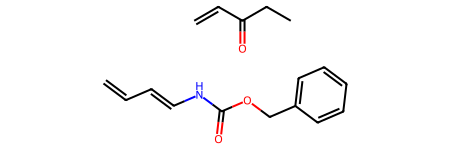

In [34]:
idx = 5
print(df['labels'].values[idx])
Chem.MolFromSmiles(df['substrates'].values[idx])

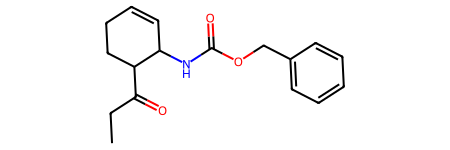

In [35]:
Chem.MolFromSmiles(df['products'].values[idx])

In [38]:
def normalize_idxs(idxs):
    scaler = StandardScaler()
    scaler.fit(idxs)
    idxs = scaler.transform(idxs)
    return 100 * idxs

def generate_fukui_plot(smiles, id):
    mol = Compound.from_smiles(smiles)
    mol.generate_conformers()
    mol.optimize_conformers()
    idxs = mol.compute_fukui_indices()
    
    new_idxs = np.array([i[id] for i in idxs]).reshape(-1, 1)
    new_idxs = normalize_idxs(new_idxs).flatten().tolist()

    d = Draw.MolDraw2DCairo(400, 400)
    SimilarityMaps.GetSimilarityMapFromWeights(Chem.AddHs(Chem.MolFromSmiles(smiles)), new_idxs, draw2d=d)
    d.FinishDrawing()
    return show_png(d.GetDrawingText())

['--chrg', '0', '--uhf', '0', '--gfn', '2', '--vfukui']
['--chrg', '0', '--uhf', '0', '--gfn', '2', '--vfukui']
['--chrg', '0', '--uhf', '0', '--gfn', '2', '--vfukui']
['--chrg', '0', '--uhf', '0', '--gfn', '2', '--vfukui']
['--chrg', '0', '--uhf', '0', '--gfn', '2', '--vfukui']
['--chrg', '0', '--uhf', '0', '--gfn', '2', '--vfukui']
['--chrg', '0', '--uhf', '0', '--gfn', '2', '--vfukui']
['--chrg', '0', '--uhf', '0', '--gfn', '2', '--vfukui']
['--chrg', '0', '--uhf', '0', '--gfn', '2', '--vfukui']
['--chrg', '0', '--uhf', '0', '--gfn', '2', '--vfukui']


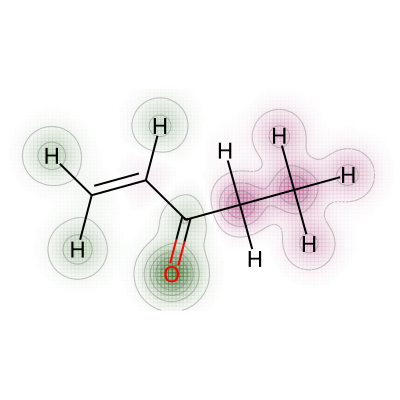

In [41]:
p = generate_fukui_plot(df['substrates'].values[idx].split('.')[0], 1)
p

['--chrg', '0', '--uhf', '0', '--gfn', '2', '--vfukui']
['--chrg', '0', '--uhf', '0', '--gfn', '2', '--vfukui']
['--chrg', '0', '--uhf', '0', '--gfn', '2', '--vfukui']
['--chrg', '0', '--uhf', '0', '--gfn', '2', '--vfukui']
['--chrg', '0', '--uhf', '0', '--gfn', '2', '--vfukui']
['--chrg', '0', '--uhf', '0', '--gfn', '2', '--vfukui']
['--chrg', '0', '--uhf', '0', '--gfn', '2', '--vfukui']
['--chrg', '0', '--uhf', '0', '--gfn', '2', '--vfukui']
['--chrg', '0', '--uhf', '0', '--gfn', '2', '--vfukui']
['--chrg', '0', '--uhf', '0', '--gfn', '2', '--vfukui']
['--chrg', '0', '--uhf', '0', '--gfn', '2', '--vfukui']
['--chrg', '0', '--uhf', '0', '--gfn', '2', '--vfukui']
['--chrg', '0', '--uhf', '0', '--gfn', '2', '--vfukui']


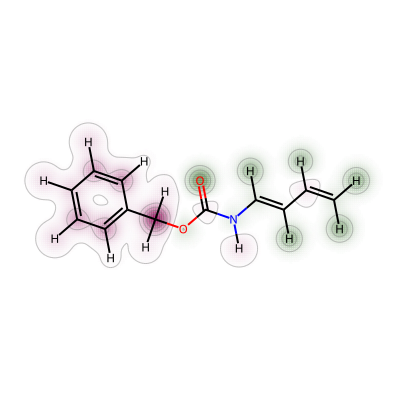

In [42]:
p = generate_fukui_plot(df['substrates'].values[idx].split('.')[1], 1)
p

In [16]:
idxs

[(0.0068000000000000005, 0.0174, 0.0121),
 (0.00495, 0.0177, 0.011399999999999999),
 (0.016450000000000003, 0.03405000000000001, 0.0252),
 (0.05115000000000001, 0.0785, 0.06484999999999999),
 (0.002750000000000001, 0.00045000000000000075, 0.0016000000000000003),
 (-0.0004500000000000006, -0.002300000000000001, -0.0013999999999999998),
 (0.0234, 0.022099999999999998, 0.02265),
 (0.01205, 0.012500000000000002, 0.012200000000000003),
 (0.0264, 0.020200000000000003, 0.02325),
 (0.008549999999999999, 0.010499999999999999, 0.0096),
 (0.0612, 0.0421, 0.051750000000000004),
 (0.013850000000000001, 0.018099999999999998, 0.015900000000000004),
 (0.03225, 0.0483, 0.04035),
 (0.03740000000000001, 0.03570000000000001, 0.03665),
 (-0.010199999999999999, -0.009150000000000002, -0.009850000000000001),
 (0.0167, 0.01315, 0.014950000000000001),
 (0.009949999999999999, 0.0063500000000000015, 0.008050000000000002),
 (0.017150000000000006, 0.01545, 0.016350000000000003),
 (0.019000000000000003, 0.01395, 0.